In [19]:
import ast
from functools import partial
import networkx as nx
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt
from dataclasses import dataclass
from mpi4py import MPI
from repast4py import context as ctx
from repast4py import core, random, schedule, logging, parameters
from repast4py.network import write_network, read_network

In [20]:
# Define the number of agents (nodes)
num_agents = 20

# Define the probability for edge creation (choose a value between 0 and 1)
# Note: Adjust p to get the desired graph density.
p = 0.05

# Create the random graph
G1 = nx.erdos_renyi_graph(n=num_agents, p=p)
G2 = nx.erdos_renyi_graph(n=num_agents, p=p)
G3 = nx.erdos_renyi_graph(n=num_agents, p=p)

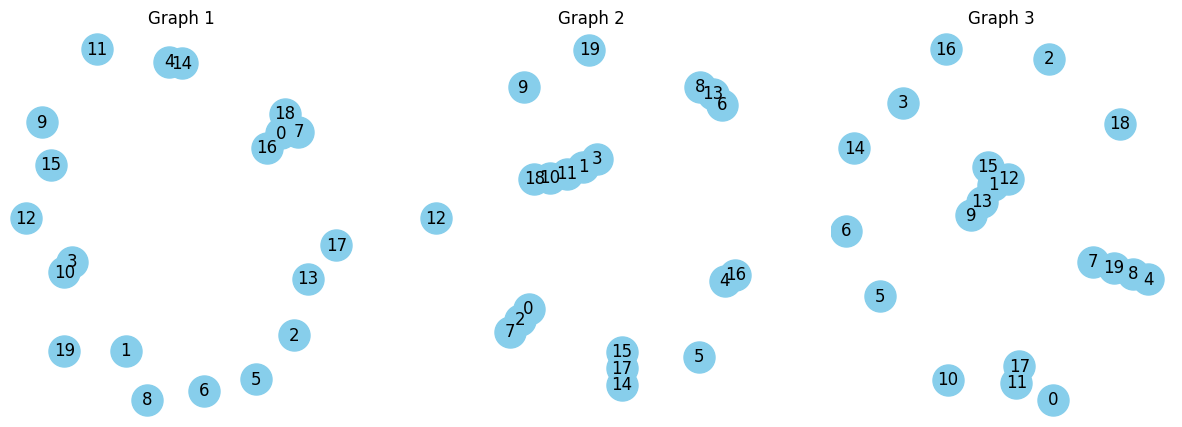

In [21]:
# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Draw each graph
graphs = [G1, G2, G3]
titles = ['Graph 1', 'Graph 2', 'Graph 3']

for i, ax in enumerate(axes):
    nx.draw(graphs[i], ax=ax, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    ax.set_title(titles[i])

plt.show()

In [22]:
write_network(G1, 'rumor_network', 'layer1.txt', 3)
write_network(G2, 'rumor_network', 'layer2.txt', 3)
write_network(G3, 'rumor_network', 'layer3.txt', 3)


In [23]:
import json
from collections import defaultdict

def parse_and_update_network_files(file_paths):
        node_info = {}
        agents = defaultdict(lambda: defaultdict(dict))
        all_nodes = set()

        for layer_index, file_path in enumerate(file_paths):
            with open(file_path, 'r') as f:
                lines = f.read().splitlines()

            if not lines:
                continue

            header = lines[0].strip().split()
            if len(header) < 2:
                continue
            directed = header[1] == '1'

            node_lines, edge_lines, found_edges = [], [], False

            for line in lines[1:]:
                if line.strip() == 'EDGES':
                    found_edges = True
                    continue
                if not found_edges and layer_index == 0:
                    node_lines.append(line.strip())
                elif found_edges:
                    edge_lines.append(line.strip())

            if layer_index == 0:
                for node_line in node_lines:
                    parts = node_line.split()
                    if len(parts) < 3:
                        continue
                    node_id, agent_type, rank = int(parts[0]), int(parts[1]), int(parts[2])
                    node_info[node_id] = (node_id, agent_type, rank)
                    all_nodes.add(node_id)

            for edge_line in edge_lines:
                parts = edge_line.split(' ', 2)
                if len(parts) < 2:
                    continue
                u_id, v_id = int(parts[0]), int(parts[1])
                if u_id not in node_info or v_id not in node_info:
                    continue
                u_tuple, v_tuple = node_info[u_id], node_info[v_id]
                attrs = json.loads(parts[2]) if len(parts) == 3 else {}
                weight = attrs.get('weight', 1.0)
                agents[u_tuple][layer_index][v_tuple] = weight
                if not directed:
                    agents[v_tuple][layer_index][u_tuple] = weight

        result = []
        for node_id in sorted(all_nodes):
            uid_tuple = node_info[node_id]
            agent_dict = {layer: {str(k): v for k, v in agents[uid_tuple].get(layer, {}).items()} for layer in range(len(file_paths))}
            result.append(agent_dict)

        with open(file_paths[0], 'r') as f:
            lines = f.read().splitlines()

        updated_lines, node_index, found_edges = [], 0, False

        for line in lines:
            if line.strip() == 'EDGES':
                found_edges = True
            if not found_edges and line.strip():
                parts = line.strip().split()
                if len(parts) >= 3:
                    shadow_data = json.dumps({"shadow": result[node_index]})
                    updated_lines.append(f"{parts[0]} {parts[1]} {parts[2]} {shadow_data}")
                    node_index += 1
                else:
                    updated_lines.append(line)
            else:
                updated_lines.append(line)

        with open(file_paths[0], 'w') as f:
            f.write('\n'.join(updated_lines))

In [24]:
parse_and_update_network_files(['layer1.txt', 'layer2.txt', 'layer3.txt'])

In [25]:
model = None


class RumorAgent(core.Agent):

    def __init__(self, nid: int, agent_type: int, rank: int, received_rumor=False, shadow=None):
        super().__init__(nid, agent_type, rank)
        self.received_rumor = received_rumor
        self.shadow = shadow or {}

    def save(self):
        """Saves the state of this agent as tuple.

        A non-ghost agent will save its state using this
        method, and any ghost agents of this agent will
        be updated with that data (self.received_rumor).

        Returns:
            The agent's state
        """
        return (self.uid, self.received_rumor, self.shadow)

    def update(self, data: bool):
        """Updates the state of this agent when it is a ghost
        agent on some rank other than its local one.

        Args:
            data: the new agent state (received_rumor)
        """
        received_rumor, shadow_data = data[0], data[1]

        if not self.received_rumor and received_rumor:
            # only update if the received rumor state
            # has changed from false to true
            model.rumor_spreaders.append(self)
            self.received_rumor = received_rumor
        
        self.shadow = shadow_data


def create_rumor_agent(nid, agent_type, rank, **kwargs):
    shadow = kwargs.get('shadow', {})
    return RumorAgent(nid, agent_type, rank, shadow=shadow)


def restore_agent(agent_data):
    uid = agent_data[0]
    received_rumor = agent_data[1]
    shadow = agent_data[2] if len(agent_data) > 2 else {}  # Handle cases where shadow might not be saved
    return RumorAgent(uid[0], uid[1], uid[2], received_rumor, shadow)

In [26]:

@dataclass
class RumorCounts:
    total_rumor_spreaders: int
    new_rumor_spreaders: int


class Model:
    def __init__(self, comm, params):
        self.runner = schedule.init_schedule_runner(comm)
        self.runner.schedule_stop(params['stop.at'])
        self.runner.schedule_end_event(self.at_end)

        fpath = params['network_file']
        self.context = ctx.SharedContext(comm)
        read_network(fpath, self.context, create_rumor_agent, restore_agent)
        self.net = self.context.get_projection('rumor_network')

        self.rumor_spreaders = []
        self.rank = comm.Get_rank()
        self._seed_rumor(params['initial_rumor_count'], comm)

        rumored_count = len(self.rumor_spreaders)
        self.counts = RumorCounts(rumored_count, rumored_count)
        loggers = logging.create_loggers(self.counts, op=MPI.SUM, rank=self.rank)
        self.data_set = logging.ReducingDataSet(loggers, comm, params['counts_file'])
        self.data_set.log(0)

        self.rumor_prob = params['rumor_probability']

        # Schedule layer-specific steps
        layer_schedules = params['layer_schedules']
        for layer_id, schedule_config in enumerate(layer_schedules):
            start = schedule_config['start']
            interval = schedule_config['interval']
            self.runner.schedule_repeating_event(start, interval, partial(self.new_step, layer=layer_id))

    def _seed_rumor(self, init_rumor_count: int, comm):
        world_size = comm.Get_size()
        rumor_counts = np.zeros(world_size, dtype=np.int32)
        if self.rank == 0:
            rng = np.random.default_rng()
            for _ in range(init_rumor_count):
                idx = rng.integers(0, high=world_size)
                rumor_counts[idx] += 1

        rumor_count = np.empty(1, dtype=np.int32)
        comm.Scatter(rumor_counts, rumor_count, root=0)

        for agent in self.context.agents(count=rumor_count[0], shuffle=True):
            agent.received_rumor = True
            self.rumor_spreaders.append(agent)

    def at_end(self):
        self.data_set.close()

    def new_step(self, layer):
        new_rumor_spreaders = []
        rng = np.random.default_rng()
        for agent in self.rumor_spreaders:
            if layer not in agent.shadow:
                continue
            layer_edges = agent.shadow[layer]
            for key_str in layer_edges:
                # Parse the neighbor's UID from the string key
                try:
                    ngh_uid = ast.literal_eval(key_str)
                except:
                    continue  # Skip invalid keys
                ngh_agent = self.context.get_agent(ngh_uid)
                if ngh_agent is None:
                    continue  # Neighbor not found (shouldn't happen if network is correct)
                # Only spread to local agents that haven't received the rumor
                if ngh_agent.local_rank == self.rank and not ngh_agent.received_rumor:
                    if rng.uniform() <= self.rumor_prob:
                        ngh_agent.received_rumor = True
                        new_rumor_spreaders.append(ngh_agent)
        # Update the list of rumor spreaders with new local agents
        self.rumor_spreaders += new_rumor_spreaders
        # Update counts
        self.counts.new_rumor_spreaders = len(new_rumor_spreaders)
        self.counts.total_rumor_spreaders += self.counts.new_rumor_spreaders
        self.data_set.log(self.runner.schedule.tick)
        # Synchronize agents across ranks
        self.context.synchronize(restore_agent)

    def start(self):
        self.runner.execute()


In [27]:
def run(params: Dict):
    global model
    model = Model(MPI.COMM_WORLD, params)
    model.start()


if __name__ == "__main__":
    params = {
        'layer_schedules': [
            {'start': 1, 'interval': 1},
            {'start': 2, 'interval': 2},
            {'start': 3, 'interval': 3}
        ],
        'network_file': 'network_1.txt',
        'initial_rumor_count': 5,
        'stop.at': 100,
        'rumor_probability': 0.1,
        'counts_file': 'output/rumor_counts.csv'
    }
    run(params)